<a href="https://colab.research.google.com/github/carldegs/EE-286/blob/master/EE286_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Genre Classifier

Narz Marbeth David 2005-09925
Carl Justin de Guia 2011-06521

## Introduction
// TODO

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')

## Dataset

// TODO

In [2]:
# TODO: Import dataset and show graphs and stuff

## Feature Extraction

// TODO: Show feature extraction methods used and how we chose what data to use in our model.

In [3]:
# TODO: Do the extraction and show ouput data
# TODO (Minor??): Save extracted data to a .csv file to remove necessity to run feature extraction code multiple times.

## Training the Model

// TODO: Explain model used, and the input and output


In [4]:
## Read extracted feature data and split into input and output.
data = pd.read_csv('./test_data.csv')

X = data.drop(['filename', 'label'], axis=1)
y = data['label']

num_labels = len(np.unique(y))
input_size = X.shape[1]

# Standardize floats
scaler = StandardScaler()
X = scaler.fit_transform(np.array(X, dtype = float))

# convert labels to one-hot vector
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# hyperparameters
batch_size = 128
hidden_units = 256
dropout = 0.4
epochs=100

# Model is a 3-layer MLP with ReLU and dropout after each layer
model = Sequential()

model.add(Dense(hidden_units,input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(num_labels))

# Output
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Train the network
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

# validation
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               6912      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2

## Results

We can measure how correct the model is by looking into the model loss and it's accuracy. Loss is a number indicating how bad the model's prediction is on a given sample. The loss should decrease as training continues. But too much training will overfit our model and increase the loss. Accuracy meanwhile determines how correct the predictions are. This is determined by using the model with a different set of inputs, the test data we separated earlier, and comparing the model's output with the actual answer. This should increase as training continues but again when the model is being trained for too long, the model will overfit and using the data from the test set will yield a lower accuracy.

For comparison, we use Pandey's [1] MLP which yields an accuracy of about 65%.

Just by changing the hyperparameters and adding some regularizers and other techniques to optimize the model, our model's accuracy increased to at maximum, 70.8%.

And after adding the **INSERT FEATURE HERE** and **INSERT OTHER FEATURE HERE**, we further increased the accuracy to INSERT BETTER ACCURACY here.


Test accuracy: 70.4%


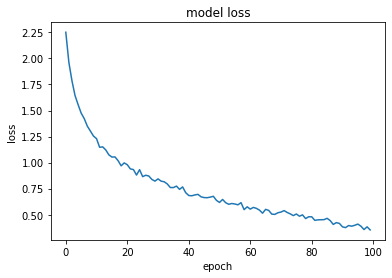

In [5]:
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


Below is the confusion matrix of the model. The matrix compares how the test samples, grouped by its actual genre (rows), is predicted by the model (columns). Ideally, all samples should be at the diagonal of the matrix.

(10.0, 0.0)

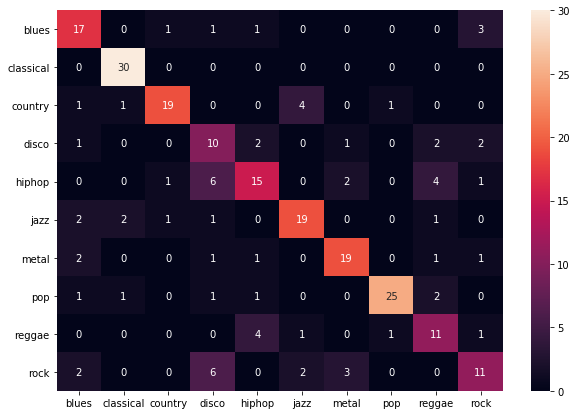

In [6]:
test_predictions = model.predict_classes(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), test_predictions)
cm_labels = label_encoder.inverse_transform(np.arange(cm.shape[0]))
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_df, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Reference

[1] Pandey, P. (2018, December 19). Music Genre Classification with Python. Retrieved from https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8.